# Rede Neural para predição da qualidade do sono

Antes de executar este notebook jupyter, primeiro execute o comando para instalar as dependências necessárias:

`
pip install -r requirements.txt
`

In [233]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

## Dataset

O dataset utilizado pode ser encontrado no [Kaggle](https://www.kaggle.com/datasets/uom190346a/sleep-and-health-metrics)

In [234]:
KAGGLE_DATASET = "uom190346a/sleep-and-health-metrics"
LABEL_COLUMN = "Sleep_Quality_Score"
SEED = 42
TEST_SIZE = 0.2

## Randomização consistente

A utilização de uma SEED fixa, permite a reprodução consistente dos mesmo resultados entre execuções

Importante para evitar resultados inesperados em execuções diferentes

In [235]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [236]:
def download_dataset(dataset: str) -> str:
    dataset_directory = kagglehub.dataset_download(dataset)

    dataset_file = os.listdir(dataset_directory)[0]

    dataset_file_path = os.path.join(dataset_directory, dataset_file)

    return dataset_file_path

In [237]:
def load_dataset(file_path: str):
    dataset = pd.read_csv(file_path)

    return dataset

## Construção/Arquitetura do modelo

A rede neural consiste de 5 camadas:
* Camada de entrada: 8 neurônios/entradas
* Camada 1: 64 nurônios, ReLU e 20% de dropout
* Camada 2: 64 nurônios, ReLU e 20% de dropout
* Camada 3: 32 nurônios, ReLU
* Camada 4: 16 nurônios, ReLU
* Camada 5: 8 nurônios, ReLU
* Camada de saída: 1 neurônio, Linear

Também há a inclusão de um regularizador "l2" para penalizar pesos muito grandes na rede, em uma tentativa de evitar overfitting dos valores

In [238]:
def build_model(dataset: pd.DataFrame, activation: str) -> keras.Model:
    input_shape = (dataset.shape[1],)

    l2_reg = regularizers.l2(1e-4)

    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Dense(64, activation=activation, kernel_regularizer=l2_reg),
            layers.Dropout(0.2),
            layers.Dense(64, activation=activation, kernel_regularizer=l2_reg),
            layers.Dropout(0.2),
            layers.Dense(32, activation=activation, kernel_regularizer=l2_reg),
            layers.Dense(16, activation=activation, kernel_regularizer=l2_reg),
            layers.Dense(8, activation=activation, kernel_regularizer=l2_reg),
            layers.Dense(1, activation="linear"),
        ]
    )

    return model

In [239]:
dataset_directory = download_dataset(KAGGLE_DATASET)

dataset = load_dataset(dataset_directory)

In [240]:
X = dataset.drop(columns=[LABEL_COLUMN])

Y = dataset[LABEL_COLUMN]

## Separação do dataset

Os dados do dataset são separados em 80% treinamento e 20% teste

In [241]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, random_state=SEED
)

## Métricas do modelo

O modelo usa como métrica de loss, o quadrado da média de erros

Onde ao invés de penalizar os error linearmente, os erros são penalizados muito mais quanto maior forem

In [242]:
activation_functions = ["relu", "tanh", "sigmoid", "linear", "leaky_relu"]

models = {}
for activation in activation_functions:
    model = build_model(X_train, activation)

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mse", "mae", "mape"],
    )

    models[activation] = model

## Treinamento

O treinamento usa o early stop para parar o treinamento antes do seu fim planejado, caso a rede se estagne em seu valor de loss, a fim de evitar overfitting e economizar recursos de hardware quando não mais crescimento real da rede

In [243]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

for activation, model in models.items():
    print(f'Função de ativação: {activation}')

    model.fit(
        X_train,
        Y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        callbacks=[early_stop]
    )

Função de ativação: relu
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25.1761 - mae: 3.7243 - mape: 247.4260 - mse: 25.1610 - val_loss: 8.7201 - val_mae: 2.0652 - val_mape: 96.9092 - val_mse: 8.7052
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7800 - mae: 2.4196 - mape: 146.2628 - mse: 9.7652 - val_loss: 4.3304 - val_mae: 1.4595 - val_mape: 75.4371 - val_mse: 4.3159
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6719 - mae: 2.0078 - mape: 123.4309 - mse: 6.6574 - val_loss: 2.4153 - val_mae: 1.1554 - val_mape: 70.8491 - val_mse: 2.4009
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0481 - mae: 1.6949 - mape: 105.1856 - mse: 5.0338 - val_loss: 1.7490 - val_mae: 1.0570 - val_mape: 66.0699 - val_mse: 1.7348
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4929 - mae: 1.4318 - mape: 89.5696 - mse: 3.4787 - val_loss: 1.4122 - val_mae: 0.9459 - val_mape: 57.4931 - val_mse: 1.3981
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5

## Validação

Para validação da rede, podemos observar as métricas de loss, MSE, MAE, MAPE e R2

Loss, MSE, MAE e MAPE indicam a quantidade de erros da rede, quanto mais próximo de zero melhor

O R2 compara os valores reais contra os valores preditos para dar um valor de acerto da rede, quanto mais próximo de 1.0 (100%), melhor

In [244]:
model_metrics = {}
for activation, model in models.items():
    print(f'Função de ativação: {activation}')

    test_loss, test_mse, test_mae, test_mape = model.evaluate(X_test, Y_test, verbose=0)

    Y_pred = model.predict(X_test).squeeze()

    test_mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_test)

    model_metrics[activation] = {
        "loss": test_loss,
        "mse": test_mse,
        "mae": test_mae,
        "mape": test_mape,
        "r2": r2,
    }

Função de ativação: relu
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

2025-11-20 22:00:44.838361: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Função de ativação: tanh
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Função de ativação: sigmoid
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Função de ativação: linear
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Função de ativação: leaky_relu
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [245]:
for activation, model_metric in model_metrics.items():
    print(f"Activation function: {activation}")
    print(f"Test Loss: {model_metric['loss']:.4f}")
    print(f"Test MSE: {model_metric['mse']:.4f}")
    print(f"Test MAE: {model_metric['mae']:.4f}")
    print(f"Test MAPE: {model_metric['mape']:.4f}")
    print(f"R2: {model_metric['r2']:.4f}")
    print()

Activation function: relu
Test Loss: 0.3553
Test MSE: 0.3413
Test MAE: 0.4133
Test MAPE: 21.6427
R2: 1.0000

Activation function: tanh
Test Loss: 8.5289
Test MSE: 8.5137
Test MAE: 1.6836
Test MAPE: 54.7778
R2: 1.0000

Activation function: sigmoid
Test Loss: 18.2841
Test MSE: 18.2692
Test MAE: 3.0947
Test MAPE: 141.4284
R2: 1.0000

Activation function: linear
Test Loss: 1995.1910
Test MSE: 1995.1758
Test MAE: 39.6303
Test MAPE: 3686.3118
R2: 1.0000

Activation function: leaky_relu
Test Loss: 10.7582
Test MSE: 10.7428
Test MAE: 2.2954
Test MAPE: 112.5769
R2: 1.0000



/tmp/ipykernel_243023/2786095214.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(activation_functions, rotation=30, ha="right")
/tmp/ipykernel_243023/2786095214.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(activation_functions, rotation=30, ha="right")
/tmp/ipykernel_243023/2786095214.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(activation_functions, rotation=30, ha="right")


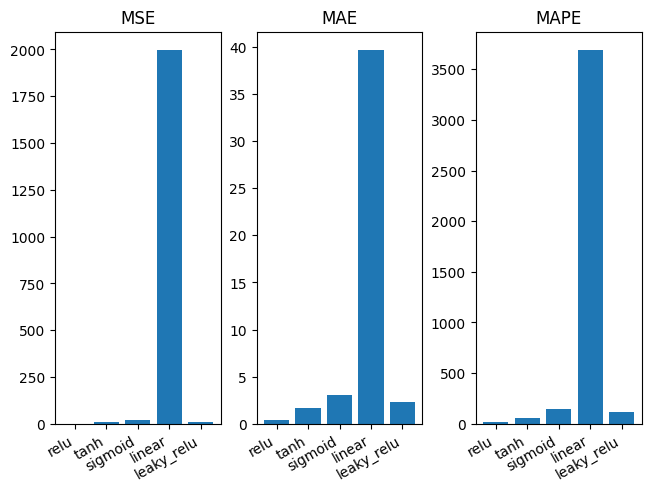

In [ ]:
fig, ax = plt.subplots(1, 3, constrained_layout=True)

ax[0].bar(activation_functions, [x["mse"] for x in model_metrics.values()])
ax[0].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[0].set_title('MSE')

ax[1].bar(activation_functions, [x["mae"] for x in model_metrics.values()])
ax[1].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[1].set_title("MAE")

ax[2].bar(activation_functions, [x["mape"] for x in model_metrics.values()])
ax[2].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[2].set_title("MAPE")

plt.show()

/tmp/ipykernel_243023/1444469925.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(activation_functions, rotation=30, ha="right")
/tmp/ipykernel_243023/1444469925.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(activation_functions, rotation=30, ha="right")
/tmp/ipykernel_243023/1444469925.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(activation_functions, rotation=30, ha="right")


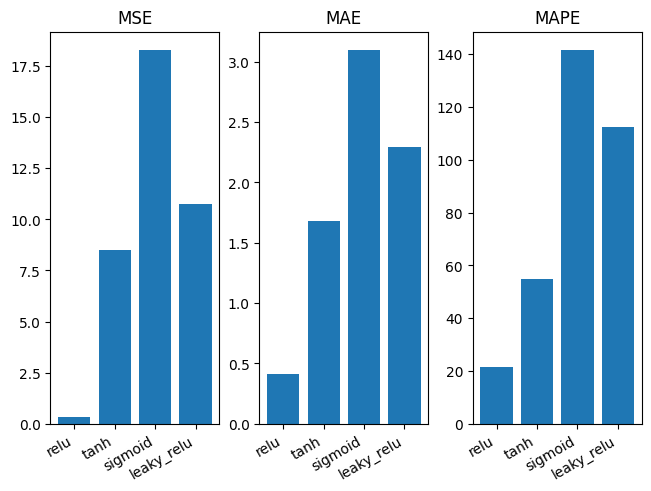

In [ ]:
fig, ax = plt.subplots(1, 3, constrained_layout=True)

# Função de atrivação linear é um outlier, e foi removida para evitar desvios na visualização dos gráficos
activation_functions.remove("linear")
model_metrics.pop("linear")

ax[0].bar(activation_functions, [x["mse"] for x in model_metrics.values()])
ax[0].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[0].set_title("MSE")

ax[1].bar(activation_functions, [x["mae"] for x in model_metrics.values()])
ax[1].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[1].set_title("MAE")

ax[2].bar(activation_functions, [x["mape"] for x in model_metrics.values()])
ax[2].set_xticklabels(activation_functions, rotation=30, ha="right")
ax[2].set_title("MAPE")

plt.show()